## Credit Card fraud detection - Classification problem

### Description
Credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Data overview
* transactions made by credit cards in September 2013 by european cardholders
* transactions that occurred in two days
* 492 frauds out of 284,807 transactions
* numerical input variables which are the result of a PCA transformation. 
* 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


Dataset from kaggle

In [1]:
pwd

'C:\\Users\\paperspace\\Desktop\\training\\Training materials I\\2. Budowa sieci MLP w Tensorflow Keras API'

In [3]:
# %load "g:/My Drive/fraud.py"
import pandas as pd
import numpy as np

df=pd.read_csv("../../../data/data/creditcard.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
from sklearn.model_selection import train_test_split
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                 test_size=.5,
                 random_state=42,stratify=y)

In [5]:
# %load "g:/My Drive/diamonds_preproc.py"
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. select labels of features for one hot encoding and standarization
num_labels = X_train.select_dtypes("number").columns
cat_labels = X_train.select_dtypes("object").columns

# 2. define preprocessor for each type of data
cat_preprocessor = OneHotEncoder(drop = "if_binary")
num_preprocessor = RobustScaler()

# 3. Combine it all together
preprocessor = ColumnTransformer([("cat", cat_preprocessor, cat_labels),
                                 ("num", num_preprocessor, num_labels)])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                 Index([], dtype='object')),
                                ('num', RobustScaler(),
                                 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])

In [6]:
#feature_labels = preprocessor.transformers_[0][1].get_feature_names_out().tolist()
#feature_labels.extend(num_labels)
feature_labels = num_labels

X_train_prepd = preprocessor.transform(X_train)
X_train_prepd = pd.DataFrame(X_train_prepd,columns = feature_labels)

X_test_prepd = preprocessor.transform(X_test)
X_test_prepd = pd.DataFrame(X_test_prepd,columns = feature_labels)

In [7]:
# Simple sequential api
from tensorflow.keras import layers
from tensorflow import keras

neg, pos = np.bincount(y_train)
total = neg + pos

#gdy zbilansowany
#neg =100
#pos =100

initial_bias = np.log(pos/neg)
initial_bias = keras.initializers.Constant(initial_bias)
initial_bias

metrics_to_monitor = [
    keras.metrics.AUC(name = "auc"),
    keras.metrics.AUC(curve="PR", name = "prc")
]

In [8]:
def model_init():
    input_layer = layers.Input(shape = (X_train_prepd.shape[1],),name = "input")

    h1 = layers.Dense(64,activation = "relu", name = "h1")(input_layer)
    h2 = layers.Dense(64,activation = "relu", name = "h2")(h1)
    h3 = layers.Dense(64,activation = "relu", name = "h3")(h2)


    output_layer = layers.Dense(1,activation = "sigmoid", name = "out",
                                bias_initializer=initial_bias)(h3)

    model = keras.Model(input_layer, output_layer)
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = metrics_to_monitor)
    return model


In [9]:
from sklearn.utils.class_weight import compute_class_weight
wagi = compute_class_weight("balanced", classes=y_train.unique(),y= y_train)

import datetime
logs_path = "logs\\"+datetime.datetime.now().strftime("%H-%M-%S")

early=keras.callbacks.EarlyStopping(monitor = "val_prc",
                                  mode = "max",
                                  patience=30,
                                  restore_best_weights=True)
   # keras.callbacks.TensorBoard(log_dir= logs_path)
cb=[early]

### Tuner

In [10]:
!pip install keras-tuner

In [11]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
hp=HyperParameters()


C:\Users\paperspace\AppData\Local\Temp\1\ipykernel_13812\2092396792.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [12]:
from kerastuner import Objective

In [13]:
def model_init(hp):
    input_layer = layers.Input(shape = (X_train_prepd.shape[1],),name = "input")

    h = layers.Dense(hp.Int('h0_units',32,128,32),
                             activation = hp.Choice('h0_act',["relu",'tanh','selu']), 
                             name = "h_0")(input_layer)
    
    for i in range(hp.Int('n_layers',1,3)):
        
        h = layers.Dense(hp.Int(f'h{i}_units',32,128,32),
                             activation = hp.Choice(f'h{i}_act',["relu",'tanh','selu']), 
                             name = f"h{i}")(h)

    output_layer = layers.Dense(1,activation = "sigmoid", name = "out",
                                bias_initializer=initial_bias)(h)

    model = keras.Model(input_layer, output_layer)
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = metrics_to_monitor)
    return model

In [43]:
tuner=RandomSearch(model_init, 
                   objective=Objective("val_prc", direction="max"), 
                   max_trials=5)

#bayesianSearch  - nie dziala losowo

In [46]:
tuner.search(X_train_prepd, y_train, batch_size=1024,epochs=100,validation_split=.2,callbacks=cb, verbose=2)

Trial 5 Complete [00h 00m 55s]
val_prc: 0.8635917901992798

Best val_prc So Far: 0.874447762966156
Total elapsed time: 00h 05m 54s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
h0_units: 64
h0_act: selu
n_layers: 1
h1_units: 32
h1_act: tanh
Score: 0.874447762966156
Trial summary
Hyperparameters:
h0_units: 96
h0_act: selu
n_layers: 1
h1_units: 96
h1_act: selu
Score: 0.8684983253479004
Trial summary
Hyperparameters:
h0_units: 128
h0_act: relu
n_layers: 2
h1_units: 32
h1_act: relu
Score: 0.8679301738739014
Trial summary
Hyperparameters:
h0_units: 96
h0_act: selu
n_layers: 2
h1_units: 128
h1_act: relu
Score: 0.8668358325958252
Trial summary
Hyperparameters:
h0_units: 64
h0_act: selu
n_layers: 2
h1_units: 96
h1_act: relu
Score: 0.8635917901992798


In [49]:
best_model=tuner.get_best_models()[0]

In [50]:
y_test_pred=best_model.predict(X_test_prepd, batch_size=5000)

29/29 [==============================] - 0s 5ms/step


In [55]:
# %load "g:/My Drive/roc_prc.py"
def plot_roc(y_test, prob, model_name = ""):
    
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    
    fpr, recall, tresh = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    
    plt.plot(fpr, recall, label = "{} AUC = {}".format(model_name, auc.round(2)))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("FPR")
    plt.ylabel("Recall")
    plt.title("ROC Curve")
    plt.legend()
    
def plot_prc(y_test, prob, model_name = ""):
    
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    
    precision, recall, tresh = precision_recall_curve(y_test, prob)
    auc = average_precision_score(y_test, prob)
    
    plt.plot(precision, recall, label = "{} AUPRC = {}".format(model_name, auc.round(2)))
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.title("Precision-Recall Curve")
    plt.legend()


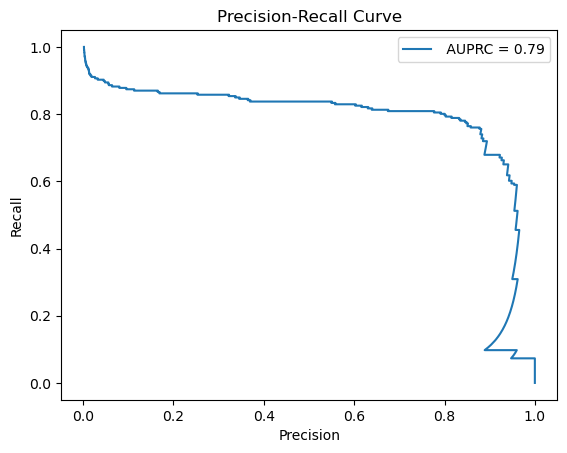

In [56]:
plot_prc(y_test,y_test_pred)